In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
path_clean_power = "./data/clean_competitor_market_prices_power.csv"

In [3]:
dtypes = {"date_valid_from": str, "date_valid_to": str, "consumption_range_kwh": np.int32, "price_year_eur": np.float64}
usecols = [name for name, _ in dtypes.items()]

In [6]:
household = pd.read_csv(path_clean_power, usecols=usecols, dtype = dtypes)

In [30]:
household.head()

,date_valid_to,date_valid_from,consumption_range_kwh,price_year_eur
0,2021-09-01,2021-06-02,3500,878.86
1,2021-09-01,2021-06-09,2800,678.69
2,2021-09-01,2021-07-10,7500,2022.68
3,2021-09-01,2021-07-10,7800,2108.47
4,2021-09-01,2021-07-10,8000,2165.66


In [54]:
household["date_valid_to"].replace({"9999-12-31": "2022-10-15"}, inplace=True)
household["price_kwh"] = household["price_year_eur"]/household["consumption_range_kwh"]

In [35]:
household["date_valid_from"] = pd.to_datetime(household["date_valid_from"])
household["date_valid_to"] = pd.to_datetime(household["date_valid_to"])

In [46]:
print(f"Earliest date: {household['date_valid_from'].min()}" +
f"Latest date: {household['date_valid_to'].max()}")

Earliest date: 2021-05-25 00:00:00Latest date: 2022-10-15 00:00:00


In [55]:
household.head()

,date_valid_to,date_valid_from,consumption_range_kwh,price_year_eur,price_kwh
0,2021-09-01,2021-06-02,3500,878.86,0.251103
1,2021-09-01,2021-06-09,2800,678.69,0.242389
2,2021-09-01,2021-07-10,7500,2022.68,0.269691
3,2021-09-01,2021-07-10,7800,2108.47,0.270317
4,2021-09-01,2021-07-10,8000,2165.66,0.270707


In [93]:
household_short = household.iloc[:2_000_000, :]

In [77]:
hh_av = pd.DataFrame(pd.date_range("2021-05-25", "2022-10-15"), columns=["date"])
hh_av["av_price_kwh"] = 0
hh_av["counter"] = 0
hh_av.head()

,date,av_price_kwh,counter
0,2021-05-25,0,0
1,2021-05-26,0,0
2,2021-05-27,0,0
3,2021-05-28,0,0
4,2021-05-29,0,0


In [ ]:
for row in household.index:
    if row%10_000 == 0:
        print(row, end = " ")
    for day in pd.date_range(household.date_valid_from.iloc[row], household.date_valid_to.iloc[row]):
        hh_av_row = hh_av.loc[hh_av["date"] == day].index
        hh_av.loc[hh_av_row,"av_price_kwh"] += household.loc[row, "price_kwh"]
        hh_av.loc[hh_av_row, "counter"] += 1

hh_av["av_price_kwh"] = hh_av["av_price_kwh"]/hh_av["counter"]

In [99]:
hh_av = household[["price_kwh", "date_valid_from"]].groupby("date_valid_from").mean()

In [100]:
hh_av.head()

,price_kwh
date_valid_from,
2021-05-25,0.632290
2021-06-01,0.292767
2021-06-02,0.251103
2021-06-08,0.448020
2021-06-09,0.242389


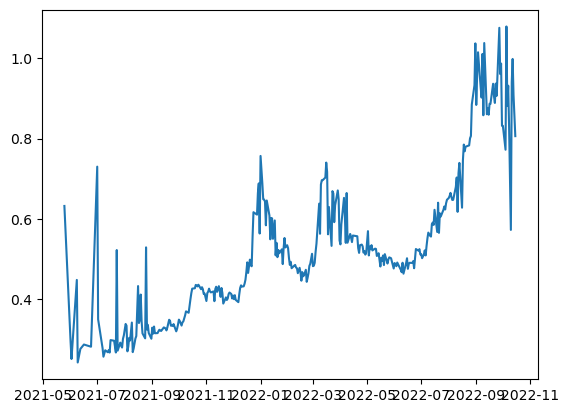

In [104]:
plt.plot(hh_av)

# Neural Network Build

In [123]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [124]:
input=layers.Input([30,44])
x = layers.LSTM(64)(input)
output= layers.Dense(1)(x)

